# Binary Classification with Neural Networks

In this notebook, we will look at binary classification using a simple neural network. We will use a synthetic dataset from Scikit-learn, represented as circles, and leverage PyTorch and Skorch for defining and training our classification model. We will save the weights of the trained model in a json file which will be used in our Aleo zk program. We will also create a script to test the outputs of our Aleo program and see if they are same as the predictions of our trained model.

## 1. Importing Necessary Libraries

Here, we import the libraries and packages necessary for data generation, manipulation, visualization, neural network modeling and training, and saving the model weights and testing scripts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier

import json

## 2. Setting Random Seeds

To ensure reproducibility and get consistent results, we set random seeds for all potential sources of randomness.


In [2]:
np.random.seed(42)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

## 3. Data Generation and Visualization

For our binary classification task, we will create a synthetic dataset consisting of two classes. The `make_circles` function generates two concentric circles, each representing a class. Visualizing this dataset provides insights into its structure and the classification challenge at hand.

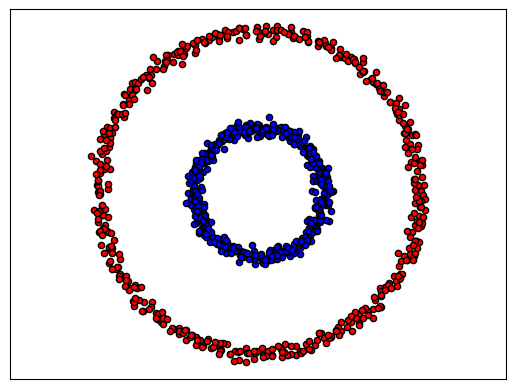

In [3]:
# Generate the dataset
model_name = "circle_fc"
data, label = make_circles(n_samples=1000, factor = 0.4, noise = 0.025)

# Visualize the dataset
def plot_data(data, label):
    reds = label == 0
    blues = label == 1
    plt.scatter(data[reds, 0], data[reds, 1], c="red", s=20, edgecolor='k')
    plt.scatter(data[blues, 0], data[blues, 1], c="blue", s=20, edgecolor='k')
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"visualization_{model_name}.png", format='png', dpi=300)
    plt.show()

plot_data(data, label)

## 4. Data Preparation

Before training our neural network, we need to convert the dataset into a data type suitable for neural network trainnig, and split it into training and testing subsets to ensure we have separate data for model evaluation.


In [4]:
X, y = data.astype(np.float32), label.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Neural Network Architecture

Our neural network is a fully-connected network which comprises an input layer, one hidden layer with relu activation function, and an output layer. Additionally, dropout is included for regularization. We also define the number of epochs and learning rate for our model.

In [5]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=2,
            hidden_dims=[10],
            output_dim=2,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))

    def forward(self, X, **kwargs):
        for i, layer in enumerate(self.layers):
            X = layer(X)
            if i != len(self.layers) - 1:  # If not the last layer
                X = self.nonlin(X)
                X = self.dropout(X)
            else:  # If last layer
                X = F.softmax(X, dim=-1)
        return X
    
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=100,
    lr=0.2)

## 6. Model Training

We now proceed to train our neural network model using the training data. Training involves feeding our network the training data multiple times (epochs) and adjusting the model weights to minimize the classification error.


In [6]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7103       0.6687        0.6878  0.0312
      2        0.7015       0.5375        0.6831  0.0091
      3        0.6938       0.6562        0.6808  0.0071
      4        0.6886       0.6875        0.6778  0.0054
      5        0.6854       0.6375        0.6734  0.0090
      6        0.6788       0.6062        0.6694  0.0043
      7        0.6786       0.6125        0.6662  0.0044
      8        0.6670       0.6562        0.6609  0.0045
      9        0.6668       0.6687        0.6554  0.0040
     10        0.6566       0.6875        0.6495  0.0041
     11        0.6649       0.7000        0.6446  0.0053
     12        0.6526       0.7438        0.6379  0.0040
     13        0.6525       0.8000        0.6325  0.0039
     14        0.6362       0.8250        0.6254  0.0060
     15        0.6444       0.8375        0.6205  0.0044
     16        0.6442       0.8

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dropout): Dropout(p=0.5, inplace=False)
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

## 7. Model Testing

We then evaluate our model's performance on unseen data (test data). This gives us an indication of whether our model has truly learned the underlying patterns in the data.


In [7]:
y_pred = net.predict(X_test)

accuracy = (sum(y_test == y_pred) / len(y_test)) * 100

print(f"Accuracy: {accuracy}%")

Accuracy: 100.0%


## 8. Save Model Parameters

A zk program usually does not support `floats`. Therefore, we define a base_scaling_factor, which is used to scale the inputs and the weights and convert them to integers. Since bias is added to `(input * weight)`, it has a scaling factor at the first layer which is twice of the base_scaling_factor. The scaling factor for biases in subsequent layers is adjusted accordingly.

We will save the trained model parameters (weights and biases) in a JSON file, making them ready for integration into a zk program.

In [8]:
base_scaling_factor = 10**6

def get_scaling_factor(layer_idx):
    scaling_factors = {
        "weight": base_scaling_factor,
        "bias": base_scaling_factor ** (layer_idx + 1)
    }
    return scaling_factors

model_data = {}

for param in net.get_all_learnable_params():
    model_data[param[0]] = param[1].detach().numpy().flatten()

model_json = {}
num_layers = len(model_data) // 2  # considering weight and bias for each layer

for i in range(num_layers):
    weight_key = f"layers.{i}.weight"
    bias_key = f"layers.{i}.bias"
    
    scaling = get_scaling_factor(i + 1)
        
    model_json[f"l{i+1}_weights"] = (model_data[weight_key] * scaling["weight"]).round().astype(int).tolist()
    model_json[f"l{i+1}_biases"] = (model_data[bias_key] * scaling["bias"]).round().astype(int).tolist()

# Save to JSON
with open(f"{model_name}_parameters.json", "w") as f:
    json.dump(model_json, f, indent=4)

print(f"Saved model parameters at {model_name}_parameters.json")

Saved model parameters at circle_fc_parameters.json


## 9. Save Test Samples

We also save the test sample inputs and corresponding model predictions in a json file. They will serve as a benchmark, enabling us to test the correctness of our zk program. The samples are again scaled appropriately for use in zk programs.

In [9]:
samples_json = {}

for (i, sample) in enumerate(zip(X_test, y_pred)):
    samples_json[f"input{i+1}"] = (sample[0]*(base_scaling_factor)).round().astype(int).tolist()
    samples_json[f"output{i+1}"] = sample[1].tolist()
    
# Save to JSON
with open(f"{model_name}_samples.json", "w") as f:
    json.dump(samples_json, f, indent=4)

print(f"Saved test samples at {model_name}_samples.json")

Saved test samples at circle_fc_samples.json
